In [1]:
# Setup
import sys
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from scipy.special import softmax

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context('notebook')

sys.path.append('/Users/sarahurbut/aladynoulli2/pyScripts/new_oct_revision')

# ------------------------------------------------------------------
# Paths
# ------------------------------------------------------------------
NO_PC_DIR = Path('/Users/sarahurbut/Library/CloudStorage/Dropbox/ret_full_nopc_withsex')
PC_DIR = Path('/Users/sarahurbut/Library/CloudStorage/Dropbox/enrollment_retrospective_full')
ANCESTRY_PATH = Path('/Users/sarahurbut/aladynoulli2/ukb.kgp_projected.tsv')
PRS_PATH = Path('/Users/sarahurbut/aladynoulli2/pyScripts/prs_with_eid.csv')
PROCESSED_IDS_PATH = Path('/Users/sarahurbut/aladynoulli2/pyScripts/processed_patient_ids.npy')

# ------------------------------------------------------------------
# Helpers
# ------------------------------------------------------------------
def load_phi_batches(base_dir: Path, n_batches: int = 41):
    """Load phi tensors from batched checkpoints."""
    phi_list = []
    for batch_idx in range(n_batches):
        start = batch_idx * 10000
        end = (batch_idx + 1) * 10000
        ckpt = base_dir / f'enrollment_model_W0.0001_batch_{start}_{end}.pt'
        if ckpt.exists():
            ckpt_state = torch.load(ckpt, map_location='cpu')
            if 'model_state_dict' in ckpt_state and 'phi' in ckpt_state['model_state_dict']:
                phi_list.append(ckpt_state['model_state_dict']['phi'].cpu().numpy())
    if not phi_list:
        raise FileNotFoundError(f'No phi tensors found in {base_dir}')
    return np.mean(phi_list, axis=0), phi_list

# ------------------------------------------------------------------
# Load tensors/metadata
# ------------------------------------------------------------------
phi_no_pc_mean, phi_no_pc_list = load_phi_batches(NO_PC_DIR)
phi_pc_mean, phi_pc_list = load_phi_batches(PC_DIR)

thetas_nopcs = torch.load('/Users/sarahurbut/aladynoulli2/pyScripts/new_thetas_with_sex_nopcs_retrospective.pt', map_location='cpu')
if hasattr(thetas_nopcs, 'numpy'):
    thetas_nopcs = thetas_nopcs.numpy()

thetas_withpcs = torch.load('/Users/sarahurbut/aladynoulli2/pyScripts/new_thetas_with_pcs_retrospective.pt', map_location='cpu')
if hasattr(thetas_withpcs, 'numpy'):
    thetas_withpcs = thetas_withpcs.numpy()

ancestry_raw = pd.read_csv(ANCESTRY_PATH, sep='\t', usecols=['eid', 'rf80']).drop_duplicates('eid')
ancestry_raw['eid_numeric'] = pd.to_numeric(ancestry_raw['eid'], errors='coerce')
ancestry_df = ancestry_raw.dropna(subset=['eid_numeric']).assign(eid_numeric=lambda d: d['eid_numeric'].astype(int))

eid_to_ancestry = dict(zip(ancestry_df['eid_numeric'], ancestry_df['rf80']))
processed_ids = np.load(PROCESSED_IDS_PATH).astype(int)
ancestry_labels = np.array([eid_to_ancestry.get(int(eid), 'UNK') for eid in processed_ids[:len(thetas_withpcs)]])

prs_df = pd.read_csv(PRS_PATH)

print('✅ Setup complete')
print(f'   phi mean shape: {phi_no_pc_mean.shape}')
print(f'   theta shapes: no PC {thetas_nopcs.shape} | with PC {thetas_withpcs.shape}')
print(f'   ancestry matched: {(ancestry_labels != "UNK").sum():,} / {len(ancestry_labels):,}')
print(f'   PRS available: {len([c for c in prs_df.columns if c != "PatientID"])} scores')


/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_81805/4234223572.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt_state = torch.load(ckpt, map_location='

✅ Setup complete
   phi mean shape: (21, 348, 52)
   theta shapes: no PC (400000, 21, 52) | with PC (400000, 21, 52)
   ancestry matched: 400,000 / 400,000
   PRS available: 36 scores


In [2]:
# FH carriers: enrichment of pre-event rise in Signature 5
# Assumes you already have in memory:
# - processed_ids: np.array of eids (N,)
# - thetas_withpcs (or thetas_nopcs): shape [N, K=21, T]
# - Y: outcomes array shape [N, D, T]
# - event_indices: list/array of indices in Y that define the CAD/ASCVD composite
# - df with ancestry (optional): columns ['eid','rf80'] if you want to stratify later
import torch
import numpy as np
import pandas as pd
from scipy.stats import fisher_exact
from statsmodels.stats.proportion import proportion_confint

# ----------------------------
# Inputs
# ----------------------------
fh_carrier_path = '/Users/sarahurbut/Downloads/out/ukb_exome_450k_fh.carrier.txt'  # ~ expanded here
Y = torch.load('/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/data_for_running/Y_tensor.pt')
if hasattr(Y, 'detach'):
    Y = Y.detach().cpu().numpy()
print(f"Y shape: {Y.shape}")
event_indices = [112, 113, 114, 115, 116]

thetas_withpcs = torch.load('/Users/sarahurbut/aladynoulli2/pyScripts/new_thetas_with_pcs_retrospective.pt', map_location='cpu')
if hasattr(thetas_withpcs, 'numpy'):
    thetas_withpcs = thetas_withpcs.numpy()
theta = thetas_withpcs   # choose which set to test
sig_idx = 5              # Signature 5 (0-based index)
pre_window = 5           # years/timepoints to look back before event
epsilon = 0.0            # >0 means strict rise; use small value like 0.002 to be conservative

# ----------------------------
# Load and align FH carriers
# ----------------------------
fh = pd.read_csv(fh_carrier_path, sep='\t', dtype={'IID': int}, low_memory=False)
# Robustly pick eid column
if 'IID' not in fh.columns:
    cand = [c for c in fh.columns if c.lower() in ('eid','id','ukb_eid','participant_id')]
    assert len(cand) > 0, f"No EID column found in {fh_carrier_path}"
    fh = fh.rename(columns={cand[0]: 'eid'})

fh_carriers = fh[['IID']].drop_duplicates()
eid_to_carrier = set(fh_carriers['IID'].astype(int).tolist())

eids = processed_ids.astype(int)
is_carrier = np.isin(eids, list(eid_to_carrier))  # [N]

# ----------------------------
# Build event flags and first event time
# ----------------------------
def to_numpy(x):
    import torch
    return x.detach().cpu().numpy() if 'torch' in str(type(x)) else x

Y_np = to_numpy(Y[:400000,])                     # [N, D, T]
ev_idx = np.array(event_indices, int)
N, K, T = theta.shape

# first event time index per person (min t where any selected event =1)
Y_sel = (Y_np[:, ev_idx, :] > 0)       # [N, |ev|, T]
has_event = Y_sel.any(axis=(1, 2))     # [N]
first_event_t = np.full(N, -1, dtype=int)
# Find first time index with any event
any_event_over_ev = Y_sel.any(axis=1)  # [N, T]
first_event_t[has_event] = np.argmax(any_event_over_ev[has_event], axis=1)

# ----------------------------
# Compute pre-event rise in Signature 5
# ----------------------------
valid = (has_event) & (first_event_t >= pre_window)  # need enough history
idx_valid = np.where(valid)[0]

sig = theta[:, sig_idx, :]  # [N, T]
pre_start = first_event_t[idx_valid] - pre_window
pre_end = first_event_t[idx_valid] - 1

# delta over window (end - start)
delta = sig[idx_valid, pre_end] - sig[idx_valid, pre_start]  # [n_valid]
is_rise = (delta > epsilon)

# Partition by carrier status
car_valid = is_carrier[idx_valid]
rise_car = is_rise[car_valid]
rise_non = is_rise[~car_valid]

n_car = rise_car.size
n_non = rise_non.size
ev_car = int(rise_car.sum())
ev_non = int(rise_non.sum())

# 2x2 table: rows = carrier vs noncarrier, cols = rise vs no-rise
table = [[ev_car, n_car - ev_car],
         [ev_non, n_non - ev_non]]
OR, p = fisher_exact(table, alternative='greater')

# Proportion CIs
car_ci = proportion_confint(ev_car, n_car, method='wilson') if n_car > 0 else (np.nan, np.nan)
non_ci = proportion_confint(ev_non, n_non, method='wilson') if n_non > 0 else (np.nan, np.nan)

print("\n=== FH carriers: enrichment of pre-event Signature 5 rise ===")
print(f"Window: last {pre_window} years before first event; epsilon={epsilon}")
print(f"Valid N with event & sufficient history: {idx_valid.size}")
print(f"Carriers:   {ev_car}/{n_car} rising  (prop={ev_car/max(n_car,1):.3f}, CI95={car_ci})")
print(f"Noncarriers:{ev_non}/{n_non} rising  (prop={ev_non/max(n_non,1):.3f}, CI95={non_ci})")
print(f"Fisher exact (greater) OR={OR:.3f}, p={p:.3e}")

# Optional: stratify by ancestry to check robustness
try:
    from collections import defaultdict
    # df_anc must exist: columns ['eid','rf80']
    anc_map = dict(zip(df['eid'].astype(int), df['rf80']))
    by_anc = defaultdict(list)
    for i, v in zip(idx_valid, is_rise[idx_valid]):
        anc = anc_map.get(int(eids[i]), 'UNK')
        by_anc[anc].append((is_carrier[i], bool(v)))
    print("\nPer-ancestry quick summary (carriers rising / carriers total | noncarriers rising / noncarriers total):")
    for anc, lst in by_anc.items():
        c_rise = sum(v for c, v in lst if c)
        c_tot = sum(1 for c, _ in lst if c)
        n_rise = sum(v for c, v in lst if not c)
        n_tot = sum(1 for c, _ in lst if not c)
        if c_tot + n_tot >= 50:  # suppress tiny strata
            print(f"  {anc}: {c_rise}/{c_tot} | {n_rise}/{n_tot}")
except Exception:
    pass

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_81805/2515953415.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  Y = torch.load('/Users/sarahurbut/Library/Cl

Y shape: (407878, 348, 52)


/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_81805/2515953415.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  thetas_withpcs = torch.load('/Users/sarahurb


=== FH carriers: enrichment of pre-event Signature 5 rise ===
Window: last 5 years before first event; epsilon=0.0
Valid N with event & sufficient history: 56308
Carriers:   445/464 rising  (prop=0.959, CI95=(0.9369339508946029, 0.9736309252363722))
Noncarriers:52208/55844 rising  (prop=0.935, CI95=(0.9328137149837256, 0.9369065594482678))
Fisher exact (greater) OR=1.631, p=1.746e-02


/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_81805/79125235.py:113: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


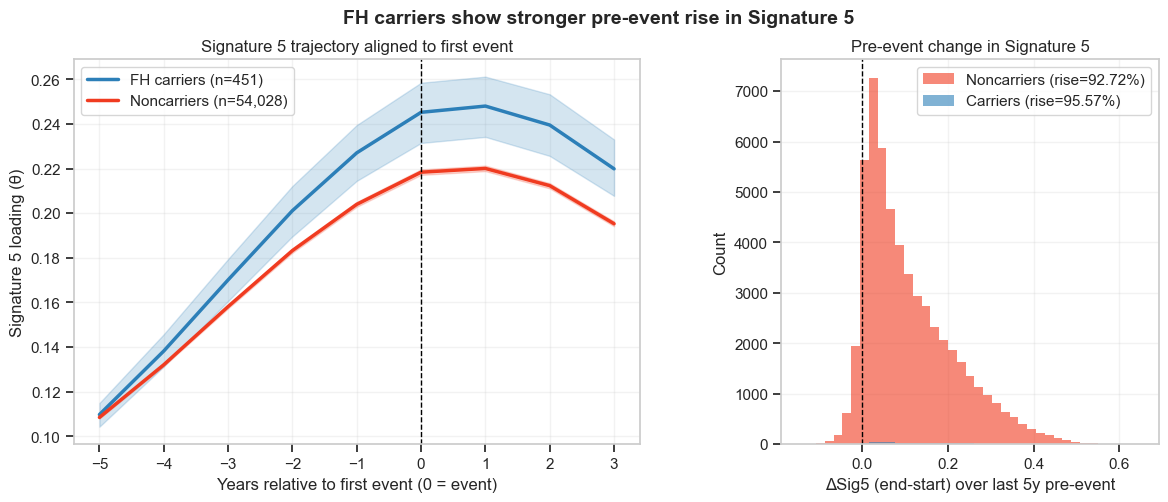

In [3]:
# Build event-aligned windows

# Visualization: FH carriers vs noncarriers — Signature 5 rise before event
# Panels:
#  (A) Event-aligned mean trajectory of Sig 5 (carriers vs noncarriers) with 95% CI
#  (B) Distribution of pre-event ΔSig5 (end-start over last 5y) + proportion rising

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import bootstrap

# Inputs already in memory:
# - processed_ids (N,), is_carrier (N bool), thetas_withpcs or thetas_nopcs as `theta` [N,K,T]
# - Y [N,D,T], event_indices (list/array)
# - Choose which theta to plot:
theta = thetas_withpcs
sig_idx = 5
pre_window = 5
post_window = 3  # for plotting after event
min_hist = pre_window  # need at least this much history

def to_numpy(x):
    import torch
    return x.detach().cpu().numpy() if 'torch' in str(type(x)) else x


N, K, T = theta.shape
ev_idx = np.array(event_indices, int)

# First event time per person
Y_sel = (Y_np[:, ev_idx, :] > 0)               # [N, |ev|, T]
has_event = Y_sel.any(axis=(1, 2))
any_ev_time = Y_sel.any(axis=1)                # [N, T]
first_ev_t = np.full(N, -1, int)
first_ev_t[has_event] = np.argmax(any_ev_time[has_event], axis=1)



sig = theta[:, sig_idx, :]                     # [N, T]
aligned_span = np.arange(-pre_window, post_window + 1)  # e.g., -5..+3
L = len(aligned_span)

def build_aligned(sig, first_t, mask):
    idx = np.where(mask & (first_t >= pre_window) & (first_t < T - post_window))[0]
    aligned = np.empty((len(idx), L), float); aligned[:] = np.nan
    for j, i in enumerate(idx):
        t0 = first_t[i]
        aligned[j] = sig[i, t0 - pre_window : t0 + post_window + 1]
    return idx, aligned

idx_car, aligned_car = build_aligned(sig, first_ev_t, is_carrier)
idx_non, aligned_non = build_aligned(sig, first_ev_t, ~is_carrier)

# Pre-event delta distributions (last 5y: end-start)
delta_car = aligned_car[:, pre_window] - aligned_car[:, 0]
delta_non = aligned_non[:, pre_window] - aligned_non[:, 0]
rise_car = (delta_car > 0).mean()
rise_non = (delta_non > 0).mean()

# Mean and 95% bootstrap CI for trajectories
def mean_ci(a, n_boot=2000, alpha=0.05):
    m = np.nanmean(a, axis=0)
    # bootstrap along rows, ignore NaNs via masking per timepoint
    ci_low, ci_high = [], []
    rng = np.random.default_rng(42)
    for t in range(a.shape[1]):
        col = a[:, t]
        col = col[~np.isnan(col)]
        if len(col) < 10:
            ci_low.append(np.nan); ci_high.append(np.nan); continue
        res = bootstrap((col,), np.mean, vectorized=False, n_resamples=n_boot,
                        paired=False, confidence_level=1-alpha, random_state=rng, method='basic')
        ci_low.append(res.confidence_interval.low)
        ci_high.append(res.confidence_interval.high)
    return m, np.array(ci_low), np.array(ci_high)

m_car, lo_car, hi_car = mean_ci(aligned_car)
m_non, lo_non, hi_non = mean_ci(aligned_non)

# Plot
fig = plt.figure(figsize=(14, 5))
gs = fig.add_gridspec(1, 2, width_ratios=[3, 2], wspace=0.3)

# (A) Event-aligned mean trajectories
ax1 = fig.add_subplot(gs[0, 0])
x = aligned_span
ax1.plot(x, m_car, color='#2c7fb8', lw=2.5, label=f'FH carriers (n={aligned_car.shape[0]:,})')
ax1.fill_between(x, lo_car, hi_car, color='#2c7fb8', alpha=0.2)
ax1.plot(x, m_non, color='#f03b20', lw=2.5, label=f'Noncarriers (n={aligned_non.shape[0]:,})')
ax1.fill_between(x, lo_non, hi_non, color='#f03b20', alpha=0.2)
ax1.axvline(0, color='k', ls='--', lw=1)
ax1.set_xlabel('Years relative to first event (0 = event)')
ax1.set_ylabel('Signature 5 loading (θ)')
ax1.set_title('Signature 5 trajectory aligned to first event')
ax1.grid(True, alpha=0.25)
ax1.legend(frameon=True)

# (B) Δ over last 5y before event
ax2 = fig.add_subplot(gs[0, 1])
bins = np.linspace(min(delta_car.min(), delta_non.min()),
                   max(delta_car.max(), delta_non.max()), 40)
ax2.hist(delta_non, bins=bins, alpha=0.6, color='#f03b20', label=f'Noncarriers (rise={rise_non:.2%})')
ax2.hist(delta_car, bins=bins, alpha=0.6, color='#2c7fb8', label=f'Carriers (rise={rise_car:.2%})')
ax2.axvline(0, color='k', ls='--', lw=1)
ax2.set_xlabel('ΔSig5 (end-start) over last 5y pre-event')
ax2.set_ylabel('Count')
ax2.set_title('Pre-event change in Signature 5')
ax2.grid(True, alpha=0.25)
ax2.legend(frameon=True)

fig.suptitle('FH carriers show stronger pre-event rise in Signature 5', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## look at relatie to general population

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import bootstrap
df_cov = pd.read_csv(
    "/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/baselinagefamh_withpcs.csv"
)
df_cov = df_cov.set_index("identifier")          # now rows are keyed by eid

baseline_age = df_cov.loc[processed_ids, "age"].to_numpy()# 
age_baseline = df_cov.loc[processed_ids, "age"].to_numpy()# 

In [34]:
refs = torch.load('/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/data_for_running/reference_trajectories.pt')
signature_refs = refs["signature_refs"]
signature_refs.shape

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_81805/3749750633.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  refs = torch.load('/Users/sarahurbut/Library/

torch.Size([20, 52])

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_81805/1195800073.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  refs = torch.load('/Users/sarahurbut/Library

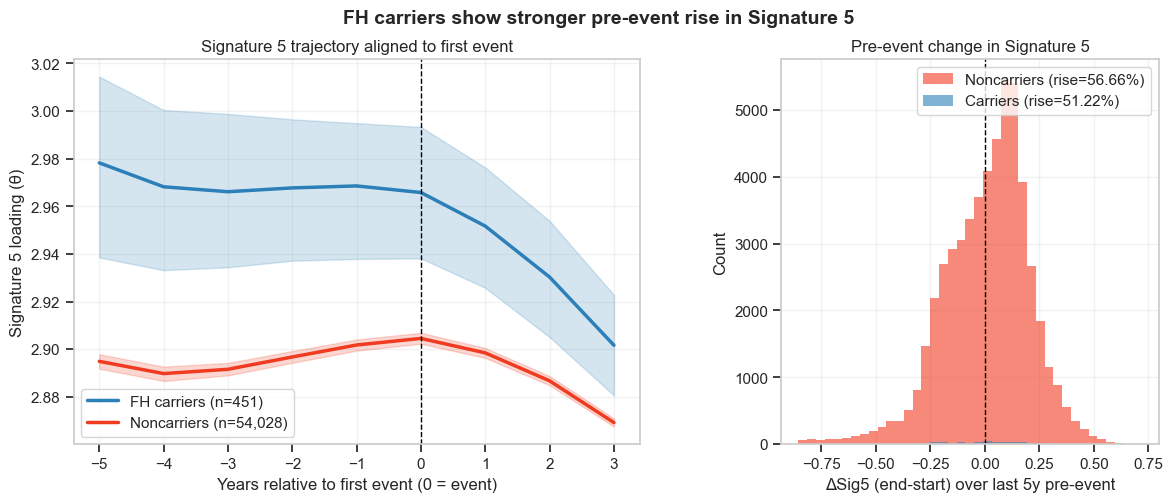

In [36]:
# Build event-aligned windows

# Visualization: FH carriers vs noncarriers — Signature 5 rise before event
# Panels:
#  (A) Event-aligned mean trajectory of Sig 5 (carriers vs noncarriers) with 95% CI
#  (B) Distribution of pre-event ΔSig5 (end-start over last 5y) + proportion rising

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import bootstrap

# Inputs already in memory:
# - processed_ids (N,), is_carrier (N bool), thetas_withpcs or thetas_nopcs as `theta` [N,K,T]
# - Y [N,D,T], event_indices (list/array)
# - Choose which theta to plot:
theta = thetas_withpcs
refs = torch.load('/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/data_for_running/reference_trajectories.pt')
signature_refs = refs["signature_refs"]
signature_refs = np.asarray(signature_refs)

sig_refs = np.asarray(signature_refs)         # shape (20, 52)
K_ref = sig_refs.shape[0]                     # should be 20

theta_centered = theta.copy()
theta_centered[:, :K_ref, :] -= sig_refs[None, :, :]   # subtract for the first 20 signatures
# healthy component, if present, is left untouched
# use theta_centered from here on

sig_idx = 5
pre_window = 5
post_window = 3  # for plotting after event
min_hist = pre_window  # need at least this much history

def to_numpy(x):
    import torch
    return x.detach().cpu().numpy() if 'torch' in str(type(x)) else x


N, K, T = theta.shape
ev_idx = np.array(event_indices, int)

# First event time per person
Y_sel = (Y_np[:, ev_idx, :] > 0)               # [N, |ev|, T]
has_event = Y_sel.any(axis=(1, 2))
any_ev_time = Y_sel.any(axis=1)                # [N, T]
first_ev_t = np.full(N, -1, int)
first_ev_t[has_event] = np.argmax(any_ev_time[has_event], axis=1)



sig = theta_centered[:, sig_idx, :]
                   # [N, T]
aligned_span = np.arange(-pre_window, post_window + 1)  # e.g., -5..+3
L = len(aligned_span)

def build_aligned(sig, first_t, mask):
    idx = np.where(mask & (first_t >= pre_window) & (first_t < T - post_window))[0]
    aligned = np.empty((len(idx), L), float); aligned[:] = np.nan
    for j, i in enumerate(idx):
        t0 = first_t[i]
        aligned[j] = sig[i, t0 - pre_window : t0 + post_window + 1]
    return idx, aligned

idx_car, aligned_car = build_aligned(sig, first_ev_t, is_carrier)
idx_non, aligned_non = build_aligned(sig, first_ev_t, ~is_carrier)

# Pre-event delta distributions (last 5y: end-start)
delta_car = aligned_car[:, pre_window] - aligned_car[:, 0]
delta_non = aligned_non[:, pre_window] - aligned_non[:, 0]
rise_car = (delta_car > 0).mean()
rise_non = (delta_non > 0).mean()

# Mean and 95% bootstrap CI for trajectories
def mean_ci(a, n_boot=2000, alpha=0.05):
    m = np.nanmean(a, axis=0)
    # bootstrap along rows, ignore NaNs via masking per timepoint
    ci_low, ci_high = [], []
    rng = np.random.default_rng(42)
    for t in range(a.shape[1]):
        col = a[:, t]
        col = col[~np.isnan(col)]
        if len(col) < 10:
            ci_low.append(np.nan); ci_high.append(np.nan); continue
        res = bootstrap((col,), np.mean, vectorized=False, n_resamples=n_boot,
                        paired=False, confidence_level=1-alpha, random_state=rng, method='basic')
        ci_low.append(res.confidence_interval.low)
        ci_high.append(res.confidence_interval.high)
    return m, np.array(ci_low), np.array(ci_high)

m_car, lo_car, hi_car = mean_ci(aligned_car)
m_non, lo_non, hi_non = mean_ci(aligned_non)

# Plot
fig = plt.figure(figsize=(14, 5))
gs = fig.add_gridspec(1, 2, width_ratios=[3, 2], wspace=0.3)

# (A) Event-aligned mean trajectories
ax1 = fig.add_subplot(gs[0, 0])
x = aligned_span
ax1.plot(x, m_car, color='#2c7fb8', lw=2.5, label=f'FH carriers (n={aligned_car.shape[0]:,})')
ax1.fill_between(x, lo_car, hi_car, color='#2c7fb8', alpha=0.2)
ax1.plot(x, m_non, color='#f03b20', lw=2.5, label=f'Noncarriers (n={aligned_non.shape[0]:,})')
ax1.fill_between(x, lo_non, hi_non, color='#f03b20', alpha=0.2)
ax1.axvline(0, color='k', ls='--', lw=1)
ax1.set_xlabel('Years relative to first event (0 = event)')
ax1.set_ylabel('Signature 5 loading (θ)')
ax1.set_title('Signature 5 trajectory aligned to first event')
ax1.grid(True, alpha=0.25)
ax1.legend(frameon=True)

# (B) Δ over last 5y before event
ax2 = fig.add_subplot(gs[0, 1])
bins = np.linspace(min(delta_car.min(), delta_non.min()),
                   max(delta_car.max(), delta_non.max()), 40)
ax2.hist(delta_non, bins=bins, alpha=0.6, color='#f03b20', label=f'Noncarriers (rise={rise_non:.2%})')
ax2.hist(delta_car, bins=bins, alpha=0.6, color='#2c7fb8', label=f'Carriers (rise={rise_car:.2%})')
ax2.axvline(0, color='k', ls='--', lw=1)
ax2.set_xlabel('ΔSig5 (end-start) over last 5y pre-event')
ax2.set_ylabel('Count')
ax2.set_title('Pre-event change in Signature 5')
ax2.grid(True, alpha=0.25)
ax2.legend(frameon=True)

fig.suptitle('FH carriers show stronger pre-event rise in Signature 5', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()